---
# Running initialization functions and imports
---

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os

import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
# Linux local
sys.path.append('/home/pbelanger/ABPlocal/BBStudies')
# Mac local
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies/')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


from init_functions import Allconfigs,load_tracked,sum_footprints, octupole_footprint,import_from_lines
display(Allconfigs)




#FIGPATH  = 'TeX/Figures/'
FIG_W = 8
FIG_H = 6

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times New Roman"
# })

# AllTracked = {}
# for line_ID in Allconfigs.index:
#     AllTracked[line_ID] = load_tracked(line_ID)

def template_FP_plot(window = 0.004,show_WP = True,show_Res = True):

    Qx_0,Qy_0 = 0.31, 0.32
    Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
    Qy_lim    = [Qy_0-4*window/6,Qy_0+2*window/6]

    if show_Res:
        bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='grey')
    if show_WP:
        h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)


    plt.axis('square')
    plt.xlim(np.array(Qx_lim)-Qx_0)
    plt.ylim(np.array(Qy_lim)-Qy_0)


    plt.xlabel(rf'$\Delta Q_x$',fontsize=16)
    plt.ylabel(rf'$\Delta Q_y$',fontsize=16)


def adjust_fontsize(fontsize=15):
    for item in ([plt.gca().title, plt.gca().xaxis.label, plt.gca().yaxis.label] +
                 plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
        item.set_fontsize(fontsize)

    if plt.gca().get_legend() is not None:
        for item in plt.gca().get_legend().get_texts():
            item.set_fontsize(fontsize)

def adjust_subplots():
    plt.subplots_adjust(left   = None,  # the left side of the subplots of the figure
                        right  = None,    # the right side of the subplots of the figure
                        bottom = None,    # the bottom of the subplots of the figure
                        top    = None,    # the top of the subplots of the figure
                        wspace = 0.001,    # the amount of width reserved for blank space between subplots
                        hspace = 0.001)    # the amount of height reserved for white space between subplots


def reverse_legend():
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend
    order = np.arange(len(labels))[::-1]

    #add legend to plot
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


config  Energy  I_bbcw  I_oct      Nb  \
line_ID                                                                        
base                 Configs/config_base.yaml    6800     350    430  1.4e11   
base_strong_01  Configs/config_strong_01.yaml    6800     350    430  1.4e11   
base_strong_02  Configs/config_strong_02.yaml    6800     350    430  1.4e11   
base_strong_03  Configs/config_strong_03.yaml    6800     350    430  1.4e11   
base_strong_04  Configs/config_strong_04.yaml    6800     350    430  1.4e11   
base_weak_01         Configs/config_base.yaml    6800     350    430  1.4e11   
base_weak_02         Configs/config_base.yaml    6800     350    430  1.4e11   
base_weak_03         Configs/config_base.yaml    6800     350    430  1.4e11   
base_weak_04         Configs/config_base.yaml    6800     350    430  1.4e11   
xing_01           Configs/config_xing_01.yaml    6800     350    430  1.4e11   
xing_02           Configs/config_xing_02.yaml    6800     350    430  1.4e11   
xing_03           Configs/config_xing_03.yaml    6800     350    430  1.4e11   
xing_04           Configs/config_xing_04.yaml    6800     350    430  1.4e11   

                emitt_strong  emitt_weak  xing  
line_ID                                         
base                     2.3         2.3   160  
base_strong_01           1.9         2.3   160  
base_strong_02           2.1         2.3   160  
base_strong_03           2.3         2.3   160  
base_strong_04           2.5         2.3   160  
base_weak_01             2.3         1.9   160  
base_weak_02             2.3         2.1   160  
base_weak_03             2.3         2.3   160  
base_weak_04             2.3         2.5   160  
xing_01                  2.3         2.3   160  
xing_02                  2.3         2.3   150  
xing_03                  2.3         2.3   140  
xing_04                  2.3         2.3   130

In [63]:


def load_tracked(line_ID,sf=10,skipfirst=15,FOLDER = 'Tracking/'):
    tracked = {}
    for label in ['ref','HO','HOLR']:
        tracked[label] = pd.read_pickle(f'{FOLDER}/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'{FOLDER}/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf
    _coord = tracked['coord']
    ctour_idx  = list(_coord[_coord['theta_sig'] == np.min(_coord['theta_sig'])].index)
    ctour_idx += list(_coord[_coord['r_sig'] == np.max(_coord['r_sig'])].index)[1:-1]
    ctour_idx += list(_coord[_coord['theta_sig'] == np.max(_coord['theta_sig'])].index)[::-1]
    ctour_idx += list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)[1:-1][::-1]
    tracked['ctour_idx'] = ctour_idx[:-skipfirst]

    tracked['co'] = list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)
    tracked['not_co'] = list(_coord[_coord['r_sig'] != np.min(_coord['r_sig'])].index)

    tracked['safe_theta'] = list(_coord[(_coord['theta_sig']>0.05*np.pi/2)&(_coord['theta_sig']<0.95*np.pi/2)].index)
    return tracked

tracked = load_tracked('base',sf=1,skipfirst=15,FOLDER = 'DAtracking/')

In [3]:
_tracked.df

NameError: name '_tracked' is not defined

In [9]:
%matplotlib widget

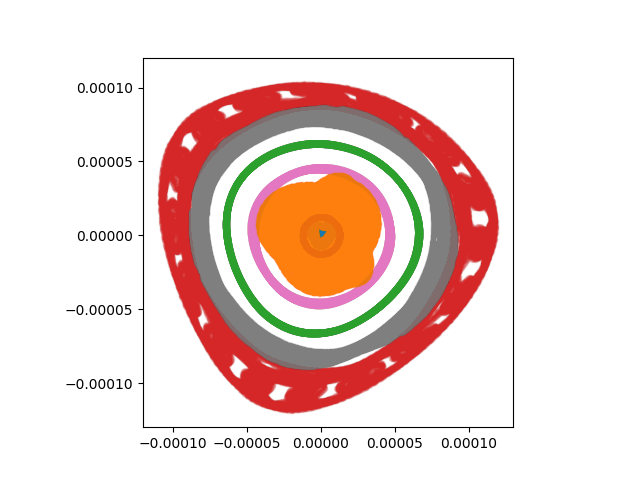

In [65]:
plt.figure()
_tracked = tracked['HOLR']
for ID,particle in _tracked.df.groupby('particle'):
    plt.plot(particle['x_n'],particle['px_n'],'.',alpha=0.05)
plt.axis('square');

/var/folders/4p/8xcc_m_x0fj78kh1xdkljjcm0000gn/T/ipykernel_19695/779712171.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


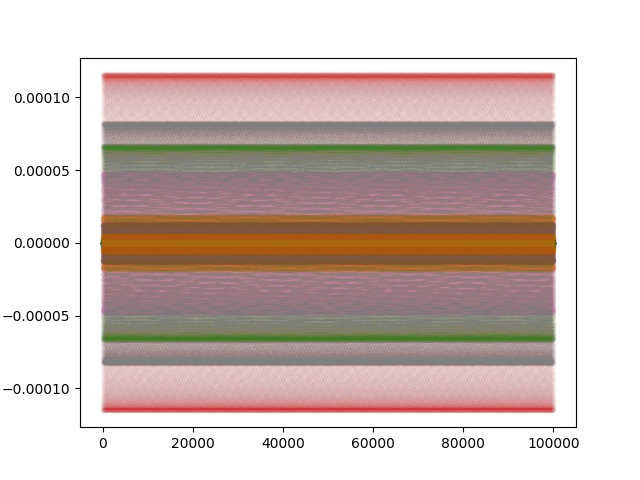

In [66]:
plt.figure()
_tracked = tracked['ref']
for ID,particle in _tracked.df.groupby('particle'):
    plt.plot(particle['turn'],particle['x_n'],'.',alpha=0.01)
#plt.axis('square');

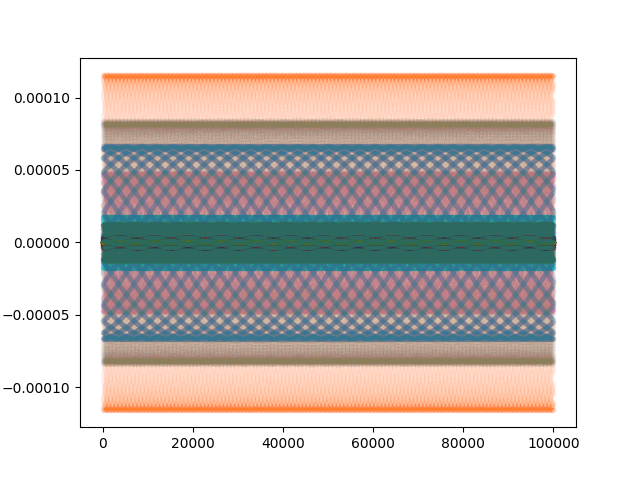

In [67]:
plt.figure()
_tracked = tracked['ref']
for ID,particle in _tracked.df.groupby('particle'):
    plt.plot(particle['turn'],particle['y_n'],'.',alpha=0.01)
#plt.axis('square');

In [68]:
plt.close('all')

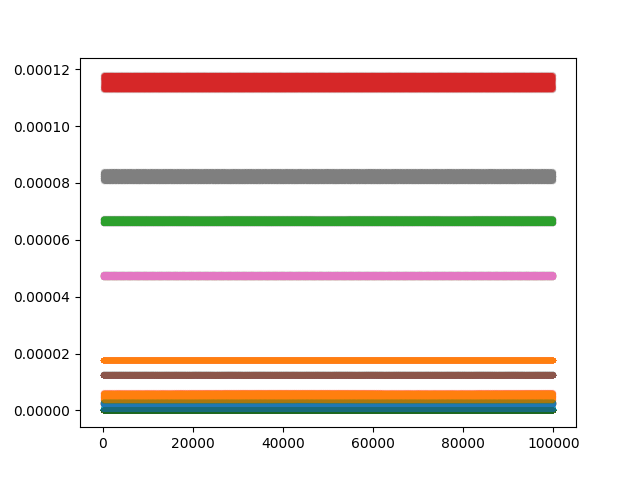

In [69]:
plt.figure()
_tracked = tracked['ref']
for ID,particle in _tracked.df.groupby('particle'):
    plt.plot(particle['turn'],np.sqrt(particle['x_n']**2+particle['px_n']**2),'.',alpha=0.01)
#plt.axis('square');

In [23]:
particle['x_n']

1100000    3.637088e-06
1100001   -2.107715e-06
1100002   -4.230703e-06
1100003    3.735399e-06
1100004   -5.945762e-08
               ...     
1199995   -1.283472e-06
1199996   -5.558532e-06
1199997    4.040100e-06
1199998    4.687083e-07
1199999   -5.925458e-06
Name: x_n, Length: 100000, dtype: float64

In [24]:
particle

turn  particle             x            px         y            py  \
1100000      0        11  4.011298e-05 -7.575753e-07  0.001711  2.069206e-05   
1100001      1        11 -2.325066e-05  1.447508e-07 -0.000729 -1.590223e-05   
1100002      2        11 -4.664820e-05  1.147150e-06 -0.001092 -7.164332e-06   
1100003      3        11  4.119842e-05 -5.361077e-07  0.001658  2.199815e-05   
1100004      4        11 -6.649730e-07 -3.794579e-07 -0.000322 -1.159102e-05   
...        ...       ...           ...           ...       ...           ...   
1199995  99995        11 -1.415418e-05 -2.214526e-07  0.000599 -1.057962e-07   
1199996  99996        11 -6.129769e-05  1.416503e-06 -0.001708 -2.000593e-05   
1199997  99997        11  4.455720e-05 -4.565047e-07  0.000855  1.712774e-05   
1199998  99998        11  5.168280e-06 -5.955656e-07  0.000977  5.372499e-06   
1199999  99999        11 -6.534504e-05  1.356024e-06 -0.001690 -2.173963e-05   

         zeta  pzeta  state           x_n          px_n       y_n  \
1100000   0.0    0.0      1  3.637088e-06 -7.461809e-11  0.000116   
1100001   0.0    0.0      1 -2.107715e-06 -3.244476e-06 -0.000049   
1100002   0.0    0.0      1 -4.230703e-06  2.934138e-06 -0.000074   
1100003   0.0    0.0      1  3.735399e-06  2.667493e-06  0.000112   
1100004   0.0    0.0      1 -5.945762e-08 -4.321369e-06 -0.000022   
...       ...    ...    ...           ...           ...       ...   
1199995   0.0    0.0      1 -1.283472e-06 -5.387575e-06  0.000040   
1199996   0.0    0.0      1 -5.558532e-06  2.854201e-06 -0.000116   
1199997   0.0    0.0      1  4.040100e-06  4.243568e-06  0.000058   
1199998   0.0    0.0      1  4.687083e-07 -5.489211e-06  0.000066   
1199999   0.0    0.0      1 -5.925458e-06  1.344929e-06 -0.000114   

                 py_n  zeta_n  pzeta_n  
1100000 -7.599027e-13     0.0      0.0  
1100001 -1.047339e-04     0.0      0.0  
1100002  8.923211e-05     0.0      0.0  
1100003  2.877534e-05     0.0      0.0  
1100004 -1.137751e-04     0.0      0.0  
...               ...     ...      ...  
1199995 -1.086195e-04     0.0      0.0  
1199996  9.619517e-06     0.0      0.0  
1199997  1.004243e-04     0.0      0.0  
1199998 -9.525400e-05     0.0      0.0  
1199999 -1.922143e-05     0.0      0.0  

[100000 rows x 15 columns]

In [28]:
np.sqrt(particle['x_n']**2+particle['px_n']**2)

turn
0        0.000004
1        0.000004
2        0.000005
3        0.000005
4        0.000004
           ...   
99995    0.000006
99996    0.000006
99997    0.000006
99998    0.000006
99999    0.000006
Length: 100000, dtype: float64

In [34]:
J_avg.dropna().values[0]

4.992321178207323e-06

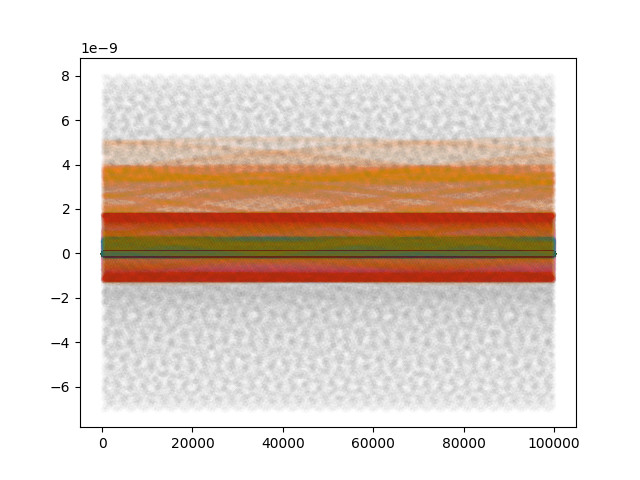

In [52]:
plt.figure()
_tracked = tracked['ref']
for ID,particle in _tracked.df.groupby('particle'):
    particle.set_index('turn',inplace=True)
    turn_avg = 200 
    J_avg    = (np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).mean()
    J_up     = np.diff(J_avg)/turn_avg

    plt.plot(particle.index,J_avg-J_avg.dropna().values[0],'.',alpha=0.01)
    #plt.plot(particle.index[:-1],J_up,'.',alpha=0.01)
#plt.axis('square');

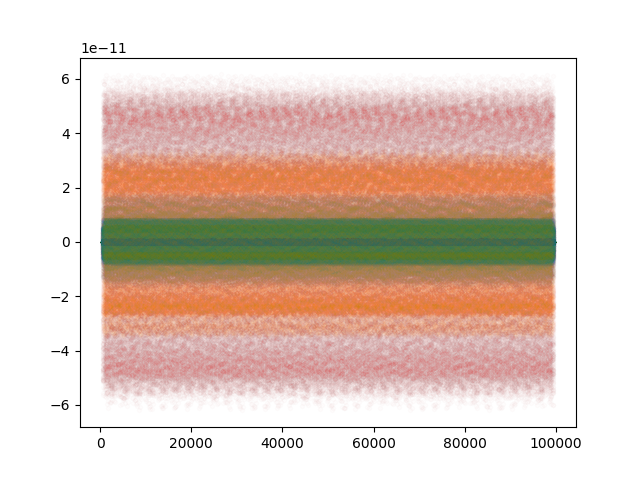

In [85]:
plt.figure()
_tracked = tracked['HOLR']
for ID,particle in _tracked.df.groupby('particle'):
    particle.set_index('turn',inplace=True)
    turn_avg = 1000 
    J_avg    = (np.sqrt(particle['y_n']**2+particle['py_n']**2)).rolling(turn_avg,center=True).mean()
    J_up     = np.diff(J_avg-np.mean(J_avg.dropna().values))/turn_avg

    # J_avg    = (np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).max()
    # J_up     = np.diff(J_avg)/turn_avg

    # plt.plot(particle.index,J_avg-np.mean(J_avg.dropna().values),'.',alpha=0.01)
    plt.plot(particle.index[:-1],J_up,'.',alpha=0.01)
#plt.axis('square');b

In [90]:
plt.close('all')

In [109]:
(np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).mean()

turn
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
99995   NaN
99996   NaN
99997   NaN
99998   NaN
99999   NaN
Length: 100000, dtype: float64

In [110]:
J_avg-np.mean(J_avg.dropna().values)

turn
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
99995   NaN
99996   NaN
99997   NaN
99998   NaN
99999   NaN
Length: 100000, dtype: float64

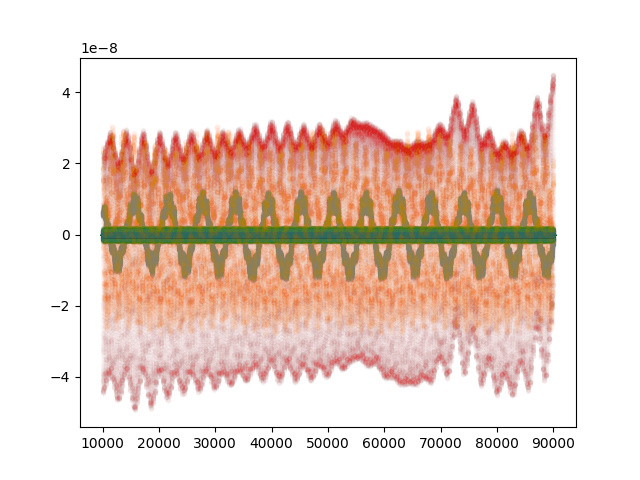

In [112]:
plt.figure()
_tracked = tracked['HOLR']
for ID,particle in _tracked.df.groupby('particle'):
    particle.set_index('turn',inplace=True)
    turn_avg = 20000 
    J_avg    = (np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).mean()
    J_up     = np.diff(J_avg-np.mean(J_avg.dropna().values))/turn_avg

    # J_avg    = (np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).max()
    # J_up     = np.diff(J_avg)/turn_avg

    plt.plot(particle.index,J_avg-np.mean(J_avg.dropna().values),'.',alpha=0.01)
    # plt.plot(particle.index[:-1],J_up,'.',alpha=0.01)
#plt.axis('square');b

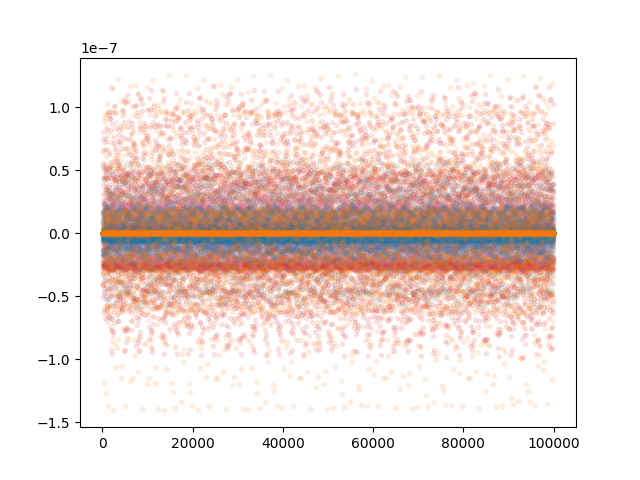

In [78]:
plt.figure()
_tracked = tracked['HOLR']
for ID,particle in _tracked.df.groupby('particle'):
    particle.set_index('turn',inplace=True)
    turn_avg = 50 
    # J_avg    = (np.sqrt(particle['y_n']**2+particle['py_n']**2)).rolling(turn_avg,center=True).mean()
    # J_up     = np.diff(J_avg)/turn_avg

    J_avg    = (np.sqrt(particle['x_n']**2+particle['px_n']**2)).rolling(turn_avg,center=True).max()
    J_up     = np.diff(J_avg)/turn_avg

    #plt.plot(particle.index,J_avg-J_avg.dropna().values[0],'.',alpha=0.01)
    plt.plot(particle.index[:-1],J_up,'.',alpha=0.1)
#plt.axis('square');

In [113]:
plt.close('all')

In [114]:
import gc
gc.collect()

747